## Installing necessary packages

In [72]:
!pip install mlflow pyngrok --quiet

## Importing necessary packages

In [73]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

## Setting up MLflow with ngrok

In [74]:
from google.colab import userdata
ngrok_token = userdata.get("ngrokToken")

In [75]:
# ngrok.kill()

In [76]:
get_ipython().system_raw("mlflow ui --port 2000 &")
mlflow.set_tracking_uri("http://localhost:2000")
from pyngrok import ngrok
ngrok.set_auth_token(ngrok_token)

In [77]:
public_url = ngrok.connect(2000).public_url
print(public_url)

https://dino-advisory-unprimitively.ngrok-free.dev


## Preprocessing dataset

In [78]:
df = pd.read_csv("/content/penguins.csv")

In [79]:
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [80]:
df.shape

(344, 5)

### Checking and dropping the null values

In [81]:
df.isna().sum()

,0
culmen_length_mm,2
culmen_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,9


In [82]:
df = df.dropna()

In [83]:
df.isna().sum()

,0
culmen_length_mm,0
culmen_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0


### Encoding the 'sex' column

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   335 non-null    float64
 1   culmen_depth_mm    335 non-null    float64
 2   flipper_length_mm  335 non-null    float64
 3   body_mass_g        335 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.7+ KB


In [85]:
le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"].astype(str))

### Scaling the data

In [86]:
scaler = StandardScaler()

In [87]:
X_scaled = scaler.fit_transform(df)

## Building and training the model

### Setting up Mlflow

2025/10/12 12:13:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/12 12:13:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run complete for eps=0.3 → Clusters: 12, Silhouette: -0.138
🏃 View run DBSCAN_eps_0.3 at: http://localhost:2000/#/experiments/828949475303588800/runs/8a038eec4a8343bfa799f4febe16afe9
🧪 View experiment at: http://localhost:2000/#/experiments/828949475303588800


2025/10/12 12:13:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/12 12:13:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run complete for eps=0.5 → Clusters: 7, Silhouette: 0.449
🏃 View run DBSCAN_eps_0.5 at: http://localhost:2000/#/experiments/828949475303588800/runs/1b5b225785424f0996e23ad4b5da00b9
🧪 View experiment at: http://localhost:2000/#/experiments/828949475303588800


2025/10/12 12:13:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/12 12:13:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run complete for eps=0.7 → Clusters: 5, Silhouette: 0.531
🏃 View run DBSCAN_eps_0.7 at: http://localhost:2000/#/experiments/828949475303588800/runs/f399b147ec324a46b81aa92490770457
🧪 View experiment at: http://localhost:2000/#/experiments/828949475303588800

All DBSCAN runs completed and logged in MLflow.


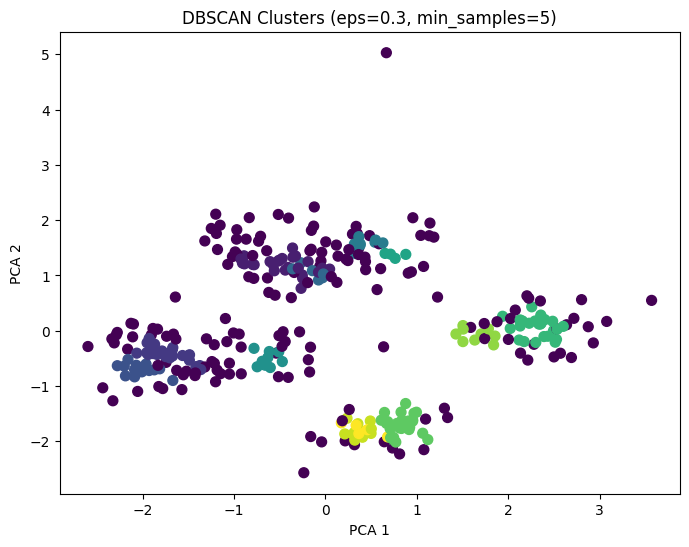

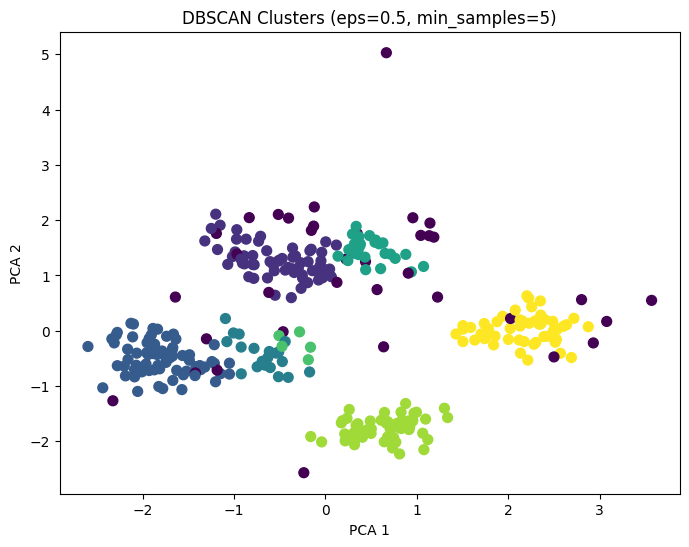

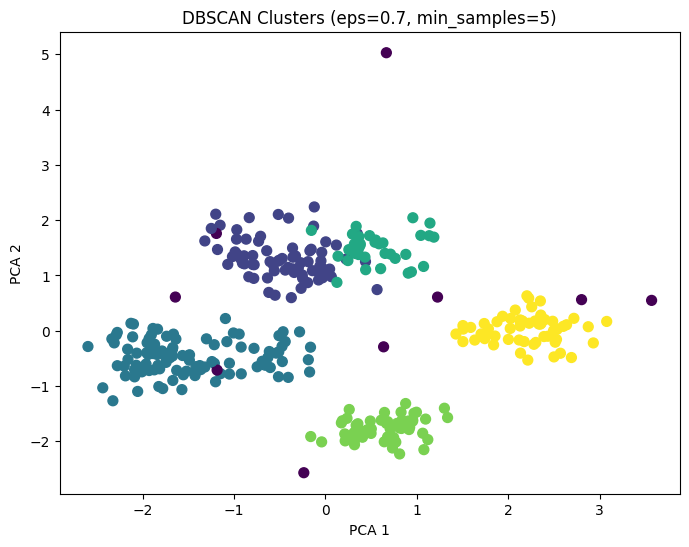

In [88]:
mlflow.set_experiment("Penguin_DBSCAN_Clustering")
eps_values = [0.3, 0.5, 0.7]
min_samples = 5

for eps in eps_values:
    with mlflow.start_run(run_name=f"DBSCAN_eps_{eps}"):

        # Building the model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Calculating the metrics
        # Silhouette is valid only if >1 cluster and < n_samples clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled, labels)
        else:
            sil_score = -1  # invalid case

        # Logging with MLflow
        mlflow.log_param("eps", eps)
        mlflow.log_param("min_samples", min_samples)
        mlflow.log_metric("n_clusters", n_clusters)
        mlflow.log_metric("silhouette_score", sil_score)

        # Visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
        plt.title(f"DBSCAN Clusters (eps={eps}, min_samples={min_samples})")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")

        mlflow.sklearn.log_model(dbscan, name=f"DBSCAN_eps_{str(eps).replace('.', '_')}")

        print(f"Run complete for eps={eps} → Clusters: {n_clusters}, Silhouette: {sil_score:.3f}")

print("\nAll DBSCAN runs completed and logged in MLflow.")